# STZ Flow Curve Fitting

**Shear Transformation Zone (STZ) model — Steady-state flow curve**

## What is STZ?

The **Shear Transformation Zone (STZ)** theory provides a microscopic framework for understanding plasticity in **amorphous solids** — materials lacking crystalline order such as metallic glasses, bulk metallic glasses, and dense colloidal suspensions. Unlike crystalline materials where plasticity occurs via dislocation motion along slip planes, amorphous solids deform through **localized rearrangements** of small clusters (~5-10 atoms), called Shear Transformation Zones.

### Physical Motivation

STZ theory addresses a fundamental question: *How do glasses flow?* At temperatures below the glass transition ($T < T_g$), these materials are kinetically arrested in deep energy minima. Yet under applied stress, they undergo plastic flow through activated "flip" events where particle clusters spontaneously rearrange, releasing local shear strain.

### Key Physics

1. **Effective temperature** $\chi$: A configurational disorder parameter (not thermal temperature) that quantifies the depth of energy traps. Unlike $T$ (kinetic energy), $\chi$ reflects the structural disorder of the inherent energy landscape. Low $\chi$ = deeply annealed glass (high yield stress), high $\chi$ = rejuvenated glass (low yield stress).

2. **STZ density** $\Lambda(\chi) = \exp(-e_z/\chi)$: The fraction of sites capable of undergoing plastic rearrangements. Exponentially sensitive to disorder.

3. **Stress-biased hopping**: Applied stress $\sigma$ biases STZ transitions via $\tanh(\sigma/\sigma_y)$, where $\sigma_y$ is the activation barrier height.

4. **Mechanical rejuvenation**: Plastic dissipation ($\sigma \dot{\gamma}^{pl}$) heats $\chi$ → more STZs activate → shear thinning. Conversely, at rest, $\chi$ cools (aging) → fewer STZs → yield stress increases.

### Rate-Dependent Flow

At steady state, the plastic strain rate is:

$$\dot{\gamma}^{pl} = \frac{\varepsilon_0}{\tau_0} \Lambda(\chi) \mathcal{C}(\sigma) \mathcal{T}(\sigma)$$

where:
- $\varepsilon_0 \approx 0.1$: strain released per STZ flip
- $\tau_0 \sim 10^{-12}$ s: molecular attempt time
- $\mathcal{C}(\sigma) = \cosh(\sigma/\sigma_y)$: total activation rate
- $\mathcal{T}(\sigma) = \tanh(\sigma/\sigma_y)$: directional bias

This yields the **arctanh flow curve** relating $\sigma$ and $\dot{\gamma}$.

### Parameters

| Parameter | Symbol | Units | Physical Meaning |
|-----------|--------|-------|------------------|
| Shear modulus | $G_0$ | Pa | Elastic stiffness |
| Yield stress | $\sigma_y$ | Pa | Activation barrier height |
| Effective temp | $\chi_{\infty}$ | — | Steady-state disorder (0 = ordered) |
| Attempt time | $\tau_0$ | s | Molecular vibration timescale |
| STZ strain | $\varepsilon_0$ | — | Strain per STZ flip (~0.1) |
| Specific heat | $c_0$ | — | Rate of $\chi$ evolution |
| Formation energy | $e_z$ | — | Cost of creating an STZ |
| Lambda relaxation | $\tau_\beta$ | s | STZ density evolution time |

> **Handbook:** For detailed theory, see the [STZ Model Handbook](../../docs/source/models/stz/stz_conventional.rst)

## Learning Objectives

- Understand the STZ theory: effective temperature $\chi$, activation barriers, and plastic flow
- Fit steady-state flow curves using the analytical arctanh formula
- Visualize $\mathcal{C}(\sigma)$ and $\mathcal{T}(\sigma)$ kernel functions
- Perform Bayesian inference with NUTS and evaluate convergence
- Calibrate parameters for use in subsequent STZ notebooks

## Prerequisites

- Basic familiarity with rheological flow curves $\sigma(\dot{\gamma})$
- Understanding of NLSQ fitting (see `01-basic-maxwell.ipynb`)
- Understanding of Bayesian inference basics (see `05-bayesian-basics.ipynb`)

## Estimated Runtime

- Fast demo (1 chain): ~1-2 min
- Full run (4 chains): ~4-6 min

## 1. Setup

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import gc
import os

# Add examples root to path for shared utilities
import sys
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.stz import STZConventional

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Targeted suppression: equinox internal deprecation (harmless, not under our control)
warnings.filterwarnings("ignore", message=".*is_leaf.*", category=DeprecationWarning)

# FAST_MODE: reduced Bayesian samples for CI; set FAST_MODE=0 for production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: Shear Transformation Zones

The STZ model (Falk & Langer 1998, Langer 2008) describes plastic flow in **amorphous solids** — metallic glasses, colloidal glasses, dense emulsions — via localized rearrangements called *Shear Transformation Zones*.

### Key concepts

**Effective temperature** $\chi$: A configurational entropy measure of structural disorder. Unlike thermal temperature, $\chi$ is driven by mechanical work and controls the density of STZs:

$$\Lambda = \exp(-e_z / \chi)$$

where $e_z$ is the STZ formation energy and $\Lambda$ is the equilibrium STZ density.

**Rate factor** $\mathcal{C}(\sigma) = \cosh(\sigma / \sigma_y)$ — total transition rate (forward + backward).

**Transition bias** $\mathcal{T}(\sigma) = \tanh(\sigma / \sigma_y)$ — net directional bias of transformations.

**Plastic strain rate:**

$$\dot{\gamma}_{\text{pl}} = \frac{2 \epsilon_0}{\tau_0} \, \Lambda \, \exp(-1/\chi) \, \mathcal{C}(\sigma) \, \mathcal{T}(\sigma)$$

### Steady-state flow curve

At steady state, $\chi \to \chi_{\infty}$ and the combined activation factor simplifies. Setting $\dot{\gamma} = \dot{\gamma}_{\text{pl}}$ and inverting yields the **arctanh formula**:

$$\sigma = \sigma_y \cdot \text{arctanh}\!\left(\frac{\dot{\gamma} \, \tau_0}{\exp\!\left[-(1 + e_z)/\chi_{\infty}\right]}\right)$$

This is **analytical** (no ODE integration), making flow curve fitting fast.

### Parameters for steady state

| Parameter | Symbol | Physical meaning |
|-----------|--------|------------------|
| `sigma_y` | $\sigma_y$ | Yield stress — activation barrier scale |
| `chi_inf` | $\chi_{\infty}$ | Steady-state effective temperature |
| `tau0` | $\tau_0$ | Molecular attempt time |
| `ez` | $e_z$ | STZ formation energy |

**Note:** G0, epsilon0, c0, and tau_beta only affect *transient* response and are **not identifiable** from steady-state data alone.

### Synthetic Data Strategy

We generate **synthetic flow curve data** from the STZ arctanh formula with known parameters, then add 3% log-normal noise. This ensures the model-data compatibility is exact, letting us focus on the fitting workflow and parameter identifiability.

The STZ arctanh formula was derived for amorphous solids where the transition from thermally-activated creep to driven flow is sharp. Real yield-stress materials (emulsions, colloidal gels) often show smoother Herschel-Bulkley behavior that the arctanh shape cannot capture. Notebooks 03-05 use real experimental data with other protocols (relaxation, creep, SAOS) where STZ performs well via ODE integration.

## 3. Generate Synthetic Data

In [3]:
# Robust path resolution for execution from any directory
import sys
from pathlib import Path

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_stz_candidates = [_nb_dir, Path("examples/stz"), _nb_dir.parent / "stz"]
for _p in _stz_candidates:
    if (_p / "stz_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break

from stz_tutorial_utils import generate_synthetic_flow_curve

gamma_dot, stress, true_params = generate_synthetic_flow_curve()

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: {gamma_dot.min():.4f} - {gamma_dot.max():.1f} 1/s")
print(f"Stress range: {stress.min():.4f} - {stress.max():.1f} Pa")
print("\nTrue parameters:")
for k, v in true_params.items():
    print(f"  {k:8s} = {v:.4g}")

Data points: 30
Shear rate range: 0.0010 - 1000.0 1/s
Stress range: 0.0051 - 376.3 Pa

True parameters:
  sigma_y  = 50
  chi_inf  = 0.26
  tau0     = 0.0001
  ez       = 0.8


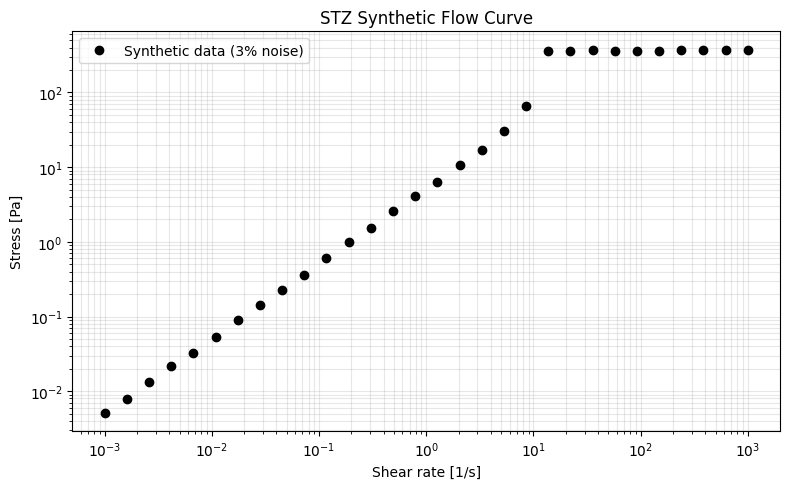

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(gamma_dot, stress, "ko", markersize=6, label="Synthetic data (3% noise)")
ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title("STZ Synthetic Flow Curve")
ax.grid(True, alpha=0.3, which="both")
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

The arctanh shape shows: linear Newtonian regime at low shear rates ($\sigma \propto \dot{\gamma}$), then a sharp upturn as the argument approaches unity. This transition is controlled by $\tau_0$ and $\chi_{\infty}$, while the overall stress scale is set by $\sigma_y$.

## 4. NLSQ Fitting

In [5]:
import time

from stz_tutorial_utils import compute_fit_quality

model = STZConventional(variant="standard")

# Non-identifiable params: constrain to tight bounds (they don't affect steady state
# but large values cause the optimizer to stall via xtol)
model.parameters.set_bounds("G0", (0.5, 2.0))
model.parameters["G0"].value = 1.0
model.parameters.set_bounds("epsilon0", (0.05, 0.2))
model.parameters["epsilon0"].value = 0.1
model.parameters.set_bounds("c0", (0.5, 2.0))
model.parameters["c0"].value = 1.0
model.parameters.set_bounds("tau_beta", (0.5, 2.0))
model.parameters["tau_beta"].value = 1.0

# Identifiable params — set bounds and initial guesses (offset from true values)
model.parameters.set_bounds("sigma_y", (1.0, 500.0))
model.parameters["sigma_y"].value = 30.0
model.parameters.set_bounds("chi_inf", (0.05, 0.5))
model.parameters["chi_inf"].value = 0.20
model.parameters.set_bounds("tau0", (1e-8, 1e0))
model.parameters["tau0"].value = 1e-3
model.parameters.set_bounds("ez", (0.1, 5.0))
model.parameters["ez"].value = 1.5

t0 = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve", use_log_residuals=True, method='scipy')
t_nlsq = time.time() - t0

stress_at_data = model.predict(gamma_dot)
quality = compute_fit_quality(stress, stress_at_data)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R-squared: {quality['r_squared']:.6f}")
print(f"RMSE: {quality['rmse']:.4f} Pa")
print("\nFitted vs true parameters (steady-state):")
for name in ["sigma_y", "chi_inf", "tau0", "ez"]:
    fitted = model.parameters.get_value(name)
    true = true_params[name]
    print(f"  {name:8s} = {fitted:.4g}  (true: {true:.4g})")

NLSQ fit time: 0.18 s
R-squared: 0.999581
RMSE: 3.4561 Pa

Fitted vs true parameters (steady-state):
  sigma_y  = 50.13  (true: 50)
  chi_inf  = 0.2567  (true: 0.26)
  tau0     = 0.0004497  (true: 0.0001)
  ez       = 0.3904  (true: 0.8)


### 4.1 Fit Quality

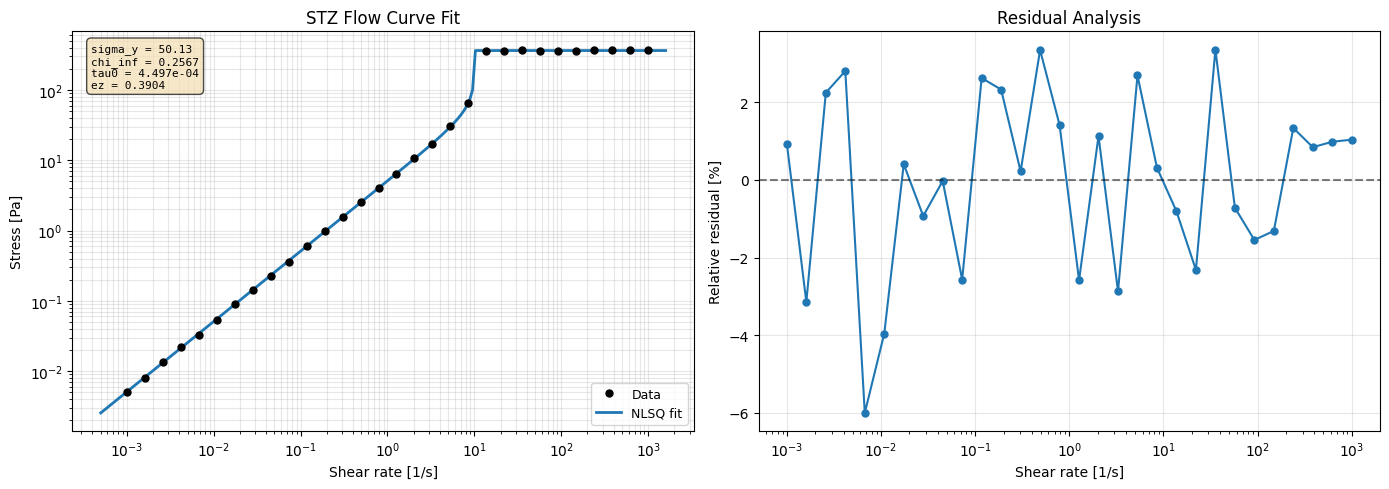

In [6]:
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.2,
    200,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: flow curve with uncertainty band
param_names = ["sigma_y", "chi_inf", "tau0", "ez"]
plot_nlsq_fit(
    gamma_dot, stress, model, test_mode="flow_curve",
    param_names=param_names,
    xlabel="Shear rate [1/s]", ylabel="Stress [Pa]",
    title="STZ Flow Curve Fit",
    ax=ax1,
)

# Right: residuals
stress_at_data = model.predict(gamma_dot)
res = (stress - stress_at_data) / stress * 100
ax2.semilogx(gamma_dot, res, "o-", markersize=5, color="C0")
ax2.axhline(0, color="black", linestyle="--", alpha=0.5)
ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("Relative residual [%]")
ax2.set_title("Residual Analysis")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

### 4.2 Physics Insight: C(sigma) and T(sigma) Kernels

The rate factor $\mathcal{C}$ and transition bias $\mathcal{T}$ are the two fundamental kernels that control STZ dynamics. Let's visualize them with the fitted yield stress.

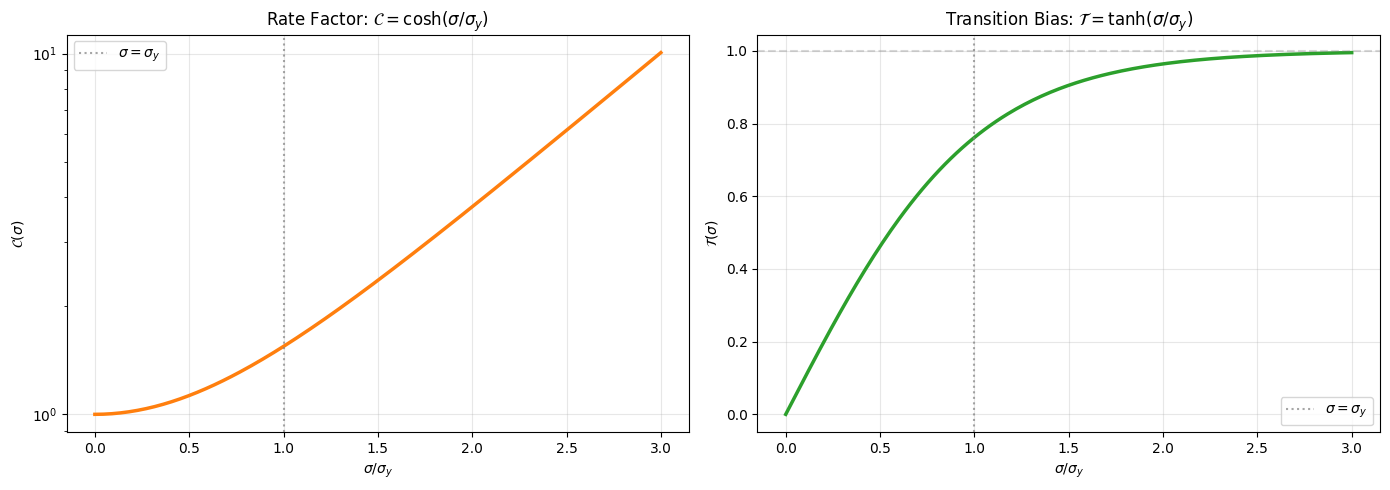

In [7]:
from rheojax.models.stz._kernels import rate_factor_C, transition_T

sigma_y_fit = model.parameters.get_value("sigma_y")
sigma_range = np.linspace(0, 3 * sigma_y_fit, 200)

C_vals = np.array([float(rate_factor_C(s, sigma_y_fit)) for s in sigma_range])
T_vals = np.array([float(transition_T(s, sigma_y_fit)) for s in sigma_range])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(sigma_range / sigma_y_fit, C_vals, "-", lw=2.5, color="C1")
ax1.axvline(1.0, color="gray", linestyle=":", alpha=0.7, label="$\\sigma = \\sigma_y$")
ax1.set_xlabel("$\\sigma / \\sigma_y$")
ax1.set_ylabel("$\\mathcal{C}(\\sigma)$")
ax1.set_title("Rate Factor: $\\mathcal{C} = \\cosh(\\sigma/\\sigma_y)$")
ax1.set_yscale("log")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(sigma_range / sigma_y_fit, T_vals, "-", lw=2.5, color="C2")
ax2.axvline(1.0, color="gray", linestyle=":", alpha=0.7, label="$\\sigma = \\sigma_y$")
ax2.axhline(1.0, color="gray", linestyle="--", alpha=0.3)
ax2.set_xlabel("$\\sigma / \\sigma_y$")
ax2.set_ylabel("$\\mathcal{T}(\\sigma)$")
ax2.set_title("Transition Bias: $\\mathcal{T} = \\tanh(\\sigma/\\sigma_y)$")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

- **$\mathcal{C}(\sigma)$** grows exponentially above $\sigma_y$, accelerating total rearrangement rate.
- **$\mathcal{T}(\sigma)$** saturates at 1.0 for $\sigma \gg \sigma_y$, meaning all transformations are forward-biased.
- Below $\sigma_y$: forward and backward transformations nearly cancel ($\mathcal{T} \approx 0$), so no net plastic flow.

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

In [8]:
# Warm-start values from NLSQ
initial_values = {
    name: model.parameters.get_value(name)
    for name in model.parameters.keys()
}
print("Warm-start values:")
for k, v in initial_values.items():
    print(f"  {k}: {v:.4g}")

# Free memory before Bayesian inference
gc.collect()
jax.clear_caches()

if FAST_MODE:
    NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 50, 100, 1
else:
    NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 1000, 2000, 4

t0 = time.time()
result = model.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=100,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values:
  G0: 1
  sigma_y: 50.13
  chi_inf: 0.2567
  tau0: 0.0004497
  epsilon0: 0.1
  c0: 1
  ez: 0.3904
  tau_beta: 1


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<02:15,  1.10it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  24%|██▍       | 36/150 [00:01<00:02, 48.36it/s, 255 steps of size 4.90e-03. acc. prob=0.82]

sample:  46%|████▌     | 69/150 [00:01<00:00, 93.64it/s, 255 steps of size 6.09e-03. acc. prob=0.98]

sample:  67%|██████▋   | 100/150 [00:01<00:00, 134.06it/s, 255 steps of size 6.09e-03. acc. prob=0.99]

sample:  87%|████████▋ | 130/150 [00:01<00:00, 168.89it/s, 255 steps of size 6.09e-03. acc. prob=0.99]

sample: 100%|██████████| 150/150 [00:01<00:00, 108.72it/s, 255 steps of size 6.09e-03. acc. prob=0.99]


Bayesian inference time: 3.7 s


### 5.2 Convergence Diagnostics

In [9]:
from stz_tutorial_utils import print_convergence_summary

param_names = ["sigma_y", "chi_inf", "tau0", "ez"]
print_convergence_summary(result, param_names)

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
--------------------------------------------------
     sigma_y    0.9933       183      PASS
     chi_inf    1.0573        12     CHECK
        tau0    1.1601        12     CHECK
          ez    1.1006        13     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


False

### 5.3 ArviZ Diagnostic Plots

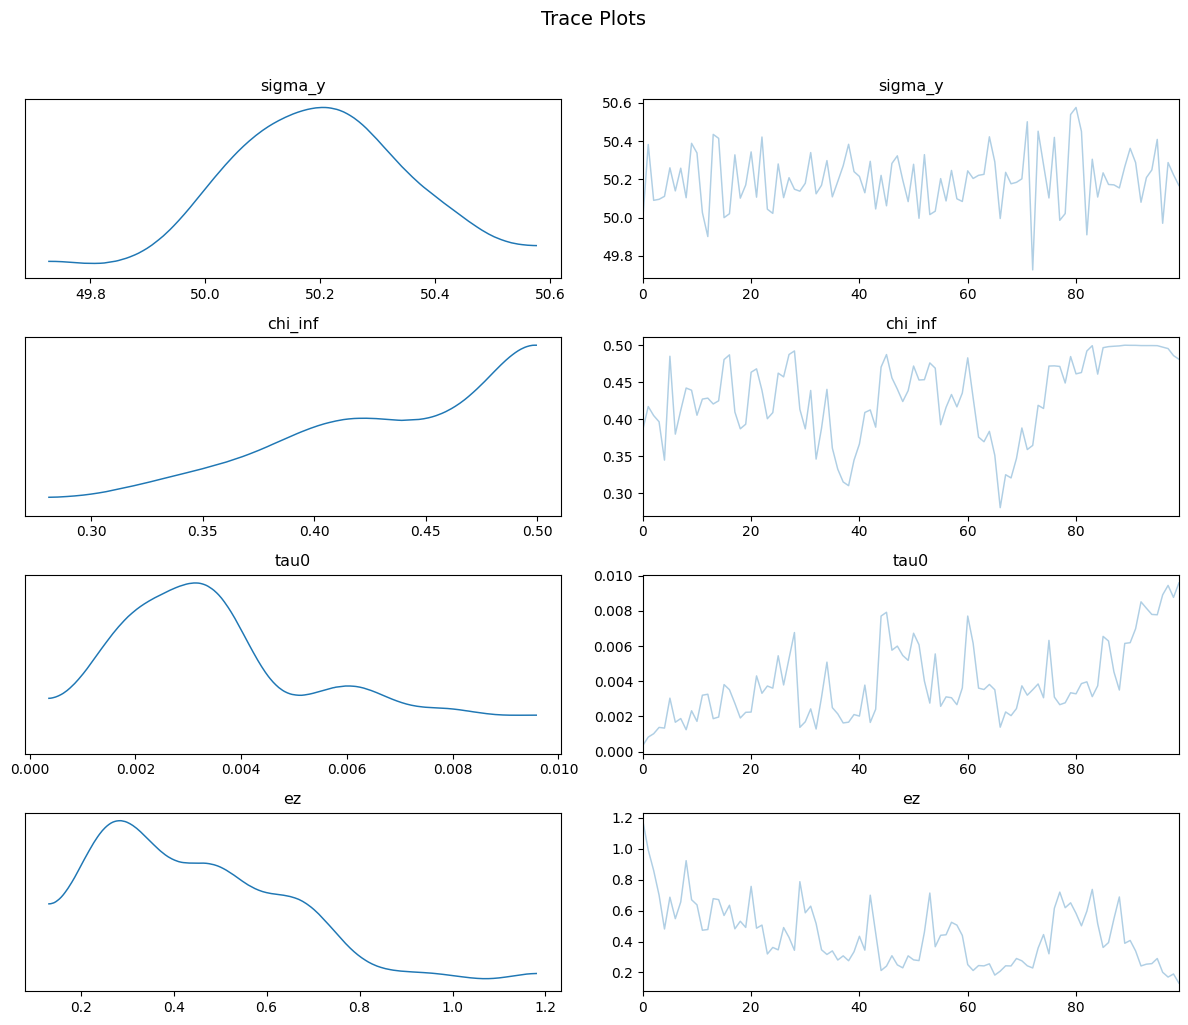

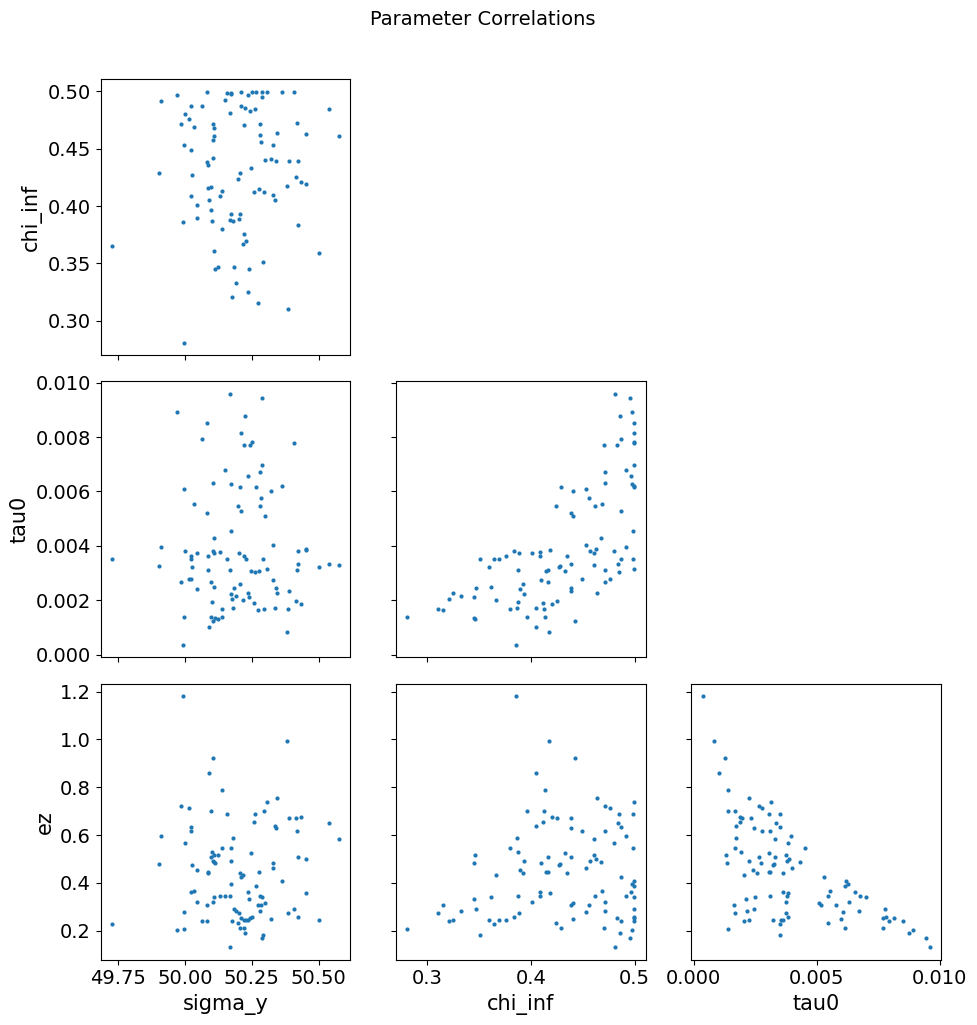

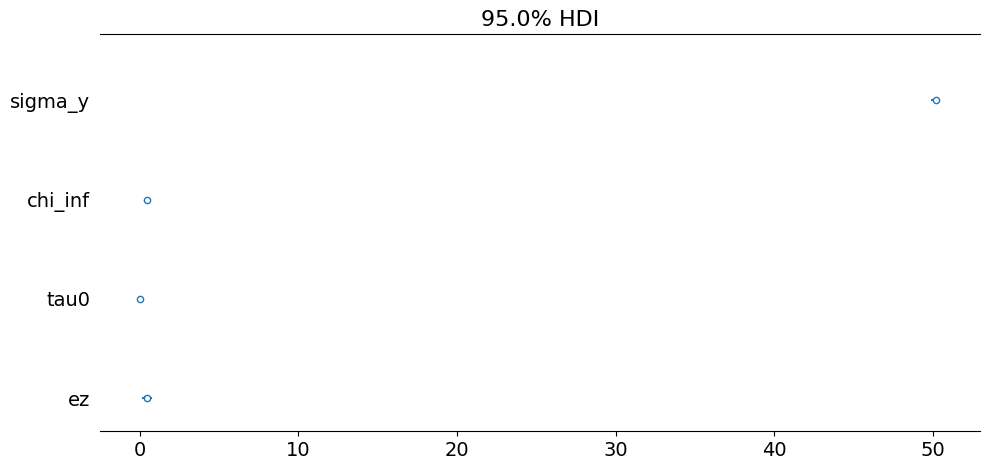

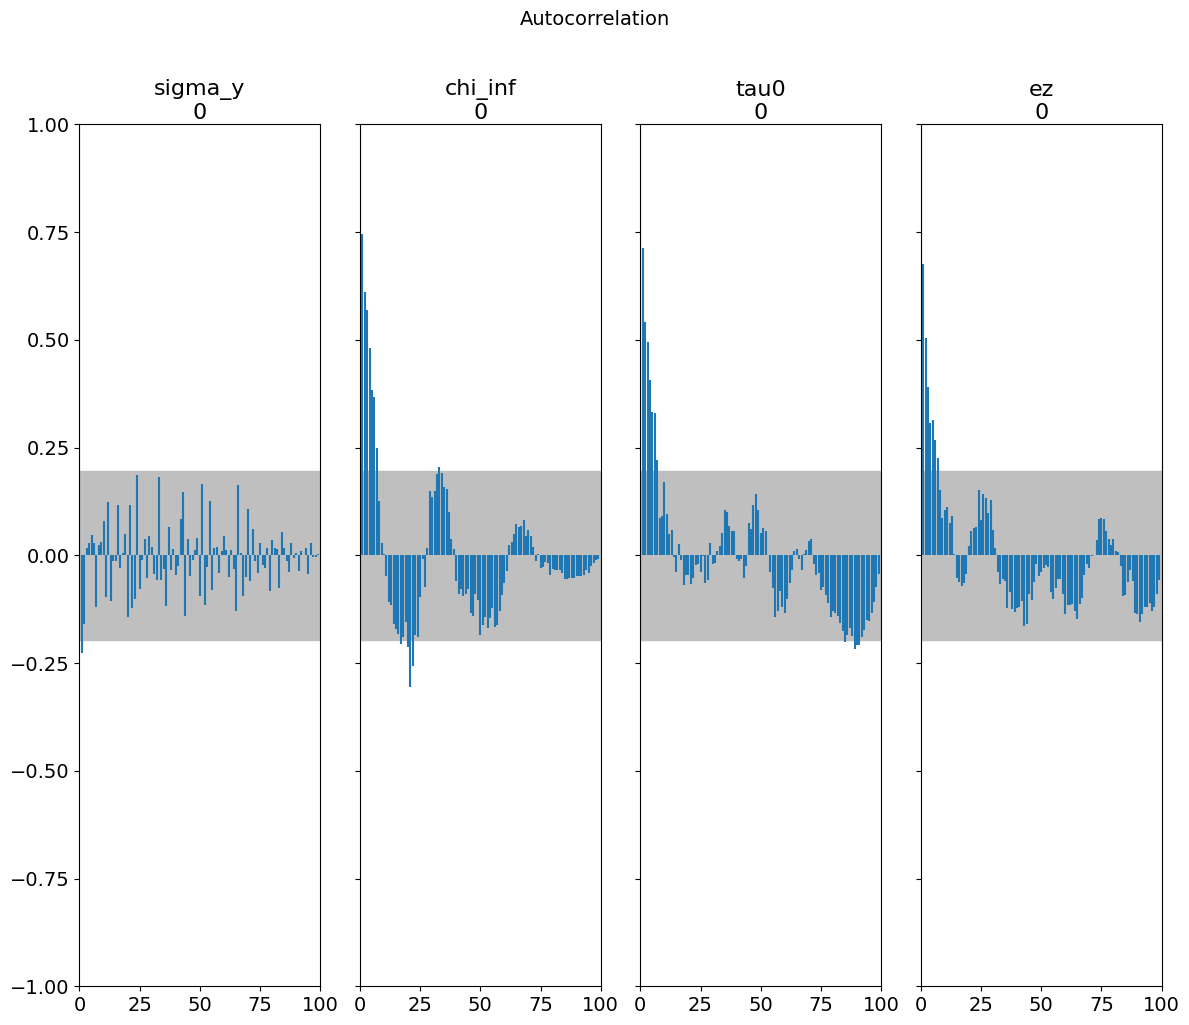

In [10]:
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

### 5.4 Posterior Predictive Check

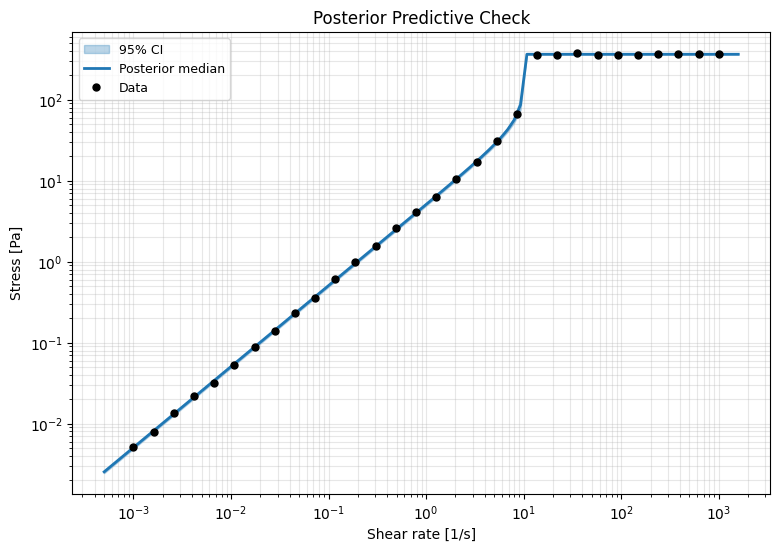

In [11]:
fig, ax = plot_posterior_predictive(
    gamma_dot, stress, model, result,
    test_mode="flow_curve", param_names=param_names,
    xlabel="Shear rate [1/s]", ylabel="Stress [Pa]",
    title="Posterior Predictive Check",
)
display(fig)
plt.close(fig)

### 5.5 Parameter Summary

In [12]:
from stz_tutorial_utils import print_parameter_comparison

posterior = result.posterior_samples
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
       Param          NLSQ        Median                    95% CI
-----------------------------------------------------------------
     sigma_y         50.17          50.2  [49.94, 50.48]
     chi_inf         0.481         0.437  [0.3181, 0.4995]
        tau0      0.009591      0.003426  [0.001127, 0.008847]
          ez        0.1308        0.4302  [0.1863, 0.8928]


## 6. Common Failure Modes

| Issue | Symptom | Fix |
|-------|---------|-----|
| arctanh argument > 1 | NaN in predictions | Reduce tau0 or increase chi_inf so activation term is large enough |
| sigma_y at lower bound | Yield stress too low | Widen lower bound or check data units (Pa vs kPa) |
| chi_inf-tau0 correlation | Banana-shaped posterior | Expected — both control activation; combine with transient data |
| Poor low-rate fit | Residuals large at low gamma_dot | Enable `use_log_residuals=True` (default) to weight all decades equally |

## 7. Save Results

Save the calibrated parameters for use in Notebooks 02 and 06 (which generate synthetic startup and LAOS data from these values).

In [13]:
from stz_tutorial_utils import save_stz_results

output_dir = os.path.join("..", "outputs", "stz", "flow_curve")
save_stz_results(model, result, output_dir, "flow_curve")

Results saved to ../outputs/stz/flow_curve/
  nlsq_params_flow_curve.json: 8 parameters
  posterior_flow_curve.json: 100 draws


## Key Takeaways

1. **STZ captures yield stress via activation barriers** — the arctanh formula directly encodes the competition between thermal activation and mechanical driving
2. **Only 4 parameters from steady state** — $G_0$, $\varepsilon_0$, $c_0$, $\tau_\beta$ require transient data (startup, relaxation, creep)
3. **$\chi_{\infty}$ encodes structural disorder** — higher $\chi_{\infty}$ means more disordered (more STZs available), lower activation barrier
4. **$\tau_0$ and $\chi_{\infty}$ are correlated** — they jointly control the activation prefactor; Bayesian inference quantifies this correlation
5. **$\mathcal{C}(\sigma)$ and $\mathcal{T}(\sigma)$ provide physical intuition** — rate factor vs directional bias decompose plastic flow into distinct mechanisms

## Next Steps

- **Notebook 02**: Use these calibrated parameters to generate startup shear data and observe stress overshoot
- **Notebook 03**: Fit stress relaxation data from laponite clay (aging behavior)
- **Notebook 05**: Fit SAOS data using the Maxwell-like linear approximation

## Further Reading

- [STZ Model Reference](../../docs/source/models/stz/stz_conventional.rst)
- Falk, M.L. & Langer, J.S. (1998). Dynamics of viscoplastic deformation in amorphous solids. *Phys. Rev. E*, 57, 7192–7205. https://doi.org/10.1103/PhysRevE.57.7192
- Langer, J.S. (2008). Shear-transformation-zone theory of plastic deformation near the glass transition. *Phys. Rev. E*, 77, 021502. https://doi.org/10.1103/PhysRevE.77.021502
- Manning, M.L., Langer, J.S., & Carlson, J.M. (2007). Strain localization in a shear transformation zone model for amorphous solids. *Phys. Rev. E*, 76, 056106. https://doi.org/10.1103/PhysRevE.76.056106
- Falk, M.L. & Langer, J.S. (2011). Deformation and failure of amorphous, solidlike materials. *Annu. Rev. Condens. Matter Phys.*, 2, 353–373. https://doi.org/10.1146/annurev-conmatphys-062910-140452